In [1]:
# !pip install matplotlib
from typing import Tuple

import torch
from torch import nn
import os
import random
from argparse import Namespace
from typing import NamedTuple

import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.decomposition import PCA
import pandas as pd
import torch
from chronos import ChronosPipeline


/home/hshastri_umass_edu/.conda/envs/amazon-chronos/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def control_randomness(seed: int = 13):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

class SyntheticDataset(nn.Module):
    def __init__(
        self,
        n_samples: int = 1024,
        seq_len: int = 512,
        freq: int = 1,
        freq_range: Tuple[int, int] = (1, 32),
        amplitude_range: Tuple[int, int] = (1, 32),
        trend_range: Tuple[int, int] = (1, 32),
        baseline_range: Tuple[int, int] = (1, 32),
        noise_mean: float = 0.0,
        noise_std: float = 0.1,
        random_seed: int = 42,
    ):
        super(SyntheticDataset, self).__init__()
        """
        Class to generate synthetic time series data.

        Parameters 
        ----------
        n_samples : int
            Number of samples to generate.
        seq_len : int
            Length of the time series.
        freq : int
            Frequency of the sinusoidal wave.
        freq_range : Tuple[int, int]
            Range of frequencies to generate.
        amplitude_range : Tuple[int, int]
            Range of amplitudes to generate.
        trend_range : Tuple[int, int]
            Range of trends to generate.
        baseline_range : Tuple[int, int]
            Range of baselines to generate.
        noise_mean : float
            Mean of the noise.
        noise_std : float
            Standard deviation of the noise.
        random_seed : int
            Random seed to control randomness.        
        """

        self.n_samples = n_samples
        self.seq_len = seq_len
        self.freq = freq
        self.freq_range = freq_range
        self.amplitude_range = amplitude_range
        self.trend_range = trend_range
        self.baseline_range = baseline_range
        self.noise_mean = noise_mean
        self.noise_std = noise_std
        self.random_seed = random_seed

        control_randomness(self.random_seed)

    def __repr__(self):
        return (
            f"SyntheticDataset(n_samples={self.n_samples},"
            + f"seq_len={self.seq_len},"
            + f"freq={self.freq},"
            + f"freq_range={self.freq_range},"
            + f"amplitude_range={self.amplitude_range},"
            + f"trend_range={self.trend_range},"
            + f"baseline_range={self.baseline_range},"
            + f"noise_mean={self.noise_mean},"
            + f"noise_std={self.noise_std},"
        )

    def _generate_noise(self):
        epsilon = torch.normal(
            mean=self.noise_mean,
            std=self.noise_std,
            size=(self.n_samples, self.seq_len),
        )

        return epsilon

    def _generate_x(self):
        t = (
            torch.linspace(start=0, end=1, steps=self.seq_len)
            .unsqueeze(0)
            .repeat(self.n_samples, 1)
        )
        x = 2 * self.freq * torch.pi * t
        return x, t

    def gen_sinusoids_with_varying_freq(self):
        c = (
            torch.linspace(
                start=self.freq_range[0], end=self.freq_range[1], steps=self.n_samples
            )
            .unsqueeze(1)
            .repeat(1, self.seq_len)
        )
        x, _ = self._generate_x()
        epsilon = self._generate_noise()

        y = torch.sin(c * x) + epsilon
        y = y.unsqueeze(1)

        return y, c

    def gen_sinusoids_with_varying_correlation(self):
        c = (
            torch.linspace(start=0, end=2 * np.pi, steps=self.n_samples)
            .unsqueeze(1)
            .repeat(1, self.seq_len)
        )
        x, _ = self._generate_x()
        epsilon = self._generate_noise()

        y = torch.sin(x + c) + epsilon
        y = y.unsqueeze(1)

        return y, c

    def gen_sinusoids_with_varying_amplitude(self):
        c = (
            torch.linspace(
                start=self.amplitude_range[0],
                end=self.amplitude_range[1],
                steps=self.n_samples,
            )
            .unsqueeze(1)
            .repeat(1, self.seq_len)
        )

        x, _ = self._generate_x()
        epsilon = self._generate_noise()

        y = c * torch.sin(x) + epsilon
        y = y.unsqueeze(1)

        return y, c

    def gen_sinusoids_with_varying_trend(self):
        c = (
            torch.linspace(
                start=self.trend_range[0], end=self.trend_range[1], steps=self.n_samples
            )
            .unsqueeze(1)
            .repeat(1, self.seq_len)
        )
        x, t = self._generate_x()
        epsilon = self._generate_noise()

        y = torch.sin(x) + t**c + epsilon
        y = y.unsqueeze(1)

        return y, c

    def gen_sinusoids_with_varying_baseline(self):
        c = (
            torch.linspace(
                start=self.baseline_range[0],
                end=self.baseline_range[1],
                steps=self.n_samples,
            )
            .unsqueeze(1)
            .repeat(1, self.seq_len)
        )
        x, _ = self._generate_x()
        epsilon = self._generate_noise()

        y = torch.sin(x) + c + epsilon
        y = y.unsqueeze(1)

        return y, c

In [3]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cuda",
    torch_dtype=torch.bfloat16,)

In [4]:
# takes in tensor of shape [batchsize, n_channels, context_length]
x = torch.randn(16, 512)
embeddings, tokenizer_state = pipeline.embed(x)
pprint(embeddings)

tensor([[[ 6.8054e-03,  8.7891e-03, -7.3547e-03,  ..., -6.4697e-03,
           1.5259e-02, -1.3733e-03],
         [ 6.1035e-04,  1.4465e-02,  6.0425e-03,  ..., -6.1035e-03,
          -1.3245e-02, -1.4648e-03],
         [ 5.1575e-03,  1.6968e-02,  1.9165e-02,  ..., -2.0905e-03,
           1.1780e-02, -1.4496e-03],
         ...,
         [-2.2316e-04,  1.9165e-02,  1.4038e-02,  ...,  7.1716e-04,
          -2.4048e-02, -1.6785e-03],
         [ 4.9133e-03,  3.0762e-02,  1.4343e-02,  ..., -2.1729e-02,
          -1.1414e-02, -1.6327e-03],
         [ 1.7578e-02,  7.5989e-03, -6.1035e-03,  ..., -2.7100e-02,
           7.2021e-03, -2.2583e-03]],

        [[ 1.4526e-02, -1.4221e-02,  1.6968e-02,  ..., -7.9956e-03,
           3.3447e-02, -1.7548e-03],
         [ 2.1729e-02, -3.6377e-02, -4.4189e-02,  ..., -4.2725e-03,
           2.9907e-02, -1.4114e-03],
         [ 9.5825e-03,  9.2163e-03, -3.1982e-02,  ..., -2.2278e-03,
           1.6098e-03, -1.7166e-03],
         ...,
         [-1.4465e-02,  6

torch.Size([1024, 1, 512])


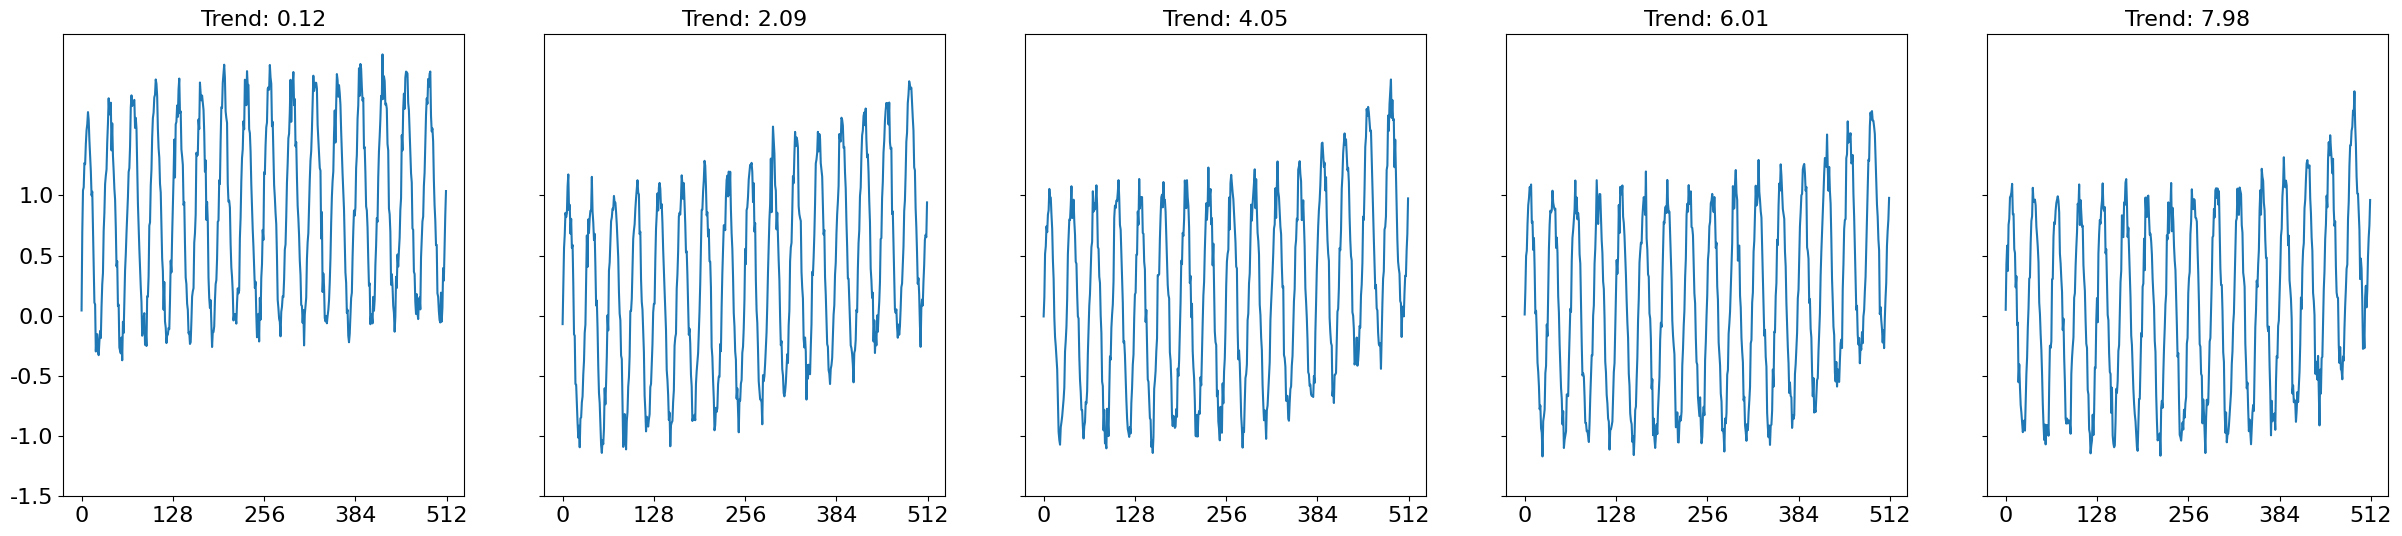

(1024, 513, 1024)


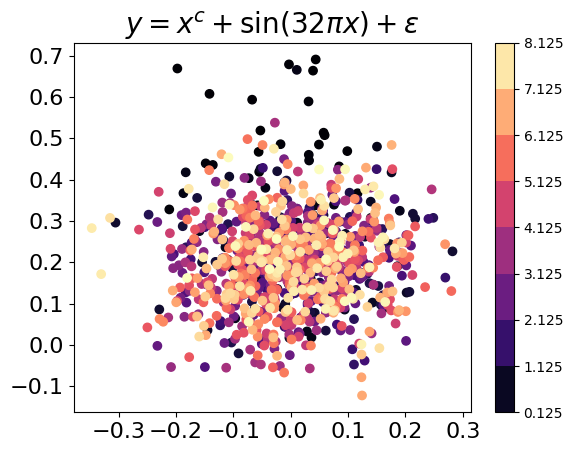

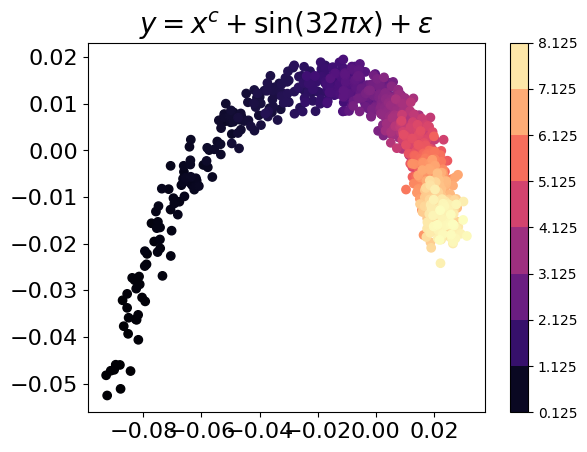

In [5]:
synthetic_dataset = SyntheticDataset(
    n_samples=1024,
    freq=16,
    trend_range=(1/8,8), 
    noise_mean=0.,
    noise_std=0.1,
    random_seed=13
)
y, c = synthetic_dataset.gen_sinusoids_with_varying_trend()
n_samples = synthetic_dataset.n_samples
seq_len = synthetic_dataset.seq_len
print(y.shape)

fig, axs = plt.subplots(1, 5, figsize=(30, 6), sharey=True)
axs.flatten()
for i, idx in enumerate(np.arange(0, n_samples+1, n_samples//4-1)):
    axs[i].plot(y[idx].squeeze().numpy())
    axs[i].set_xticks(
        ticks=np.arange(0, seq_len+1, 128), 
        labels=np.arange(0, seq_len+1, 128), 
        fontdict={"fontsize" : 16}
    )
    axs[i].set_title(
        "Trend: {:.2f}".format(c[:, 0][idx].squeeze().numpy(), ),
        fontsize=16
    )
axs[0].set_yticks(
    ticks=np.arange(-1.5, 1.5, 0.5), 
    labels=np.arange(-1.5, 1.5, 0.5),
    fontdict={"fontsize" : 16}
)
plt.show()

y_s = y.squeeze(1)
# y = y.to("cuda")

with torch.no_grad():
    embeddings, tokenizer_state = pipeline.embed(y_s)

# Move tensors and models back to CPU
y_s = y_s.detach().cpu().numpy()
embeddings = embeddings.detach().to(torch.float32).cpu().numpy()
pooled = embeddings.mean(axis=1)  # shape: [1024, 512]
print(embeddings.shape)
# Perform PCA on the embeddings
embeddings_manifold = PCA(n_components=2).fit_transform(pooled)

plt.title(f"$y = x^c+\sin(32 \pi x) + \epsilon$", fontsize=20)
plt.scatter(
    y_s[:, 0], 
    y_s[:, 1],
    c=c[:, 0].squeeze().numpy(),
    cmap='magma'
)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.colorbar(
    boundaries=np.arange(
    synthetic_dataset.trend_range[0],
    synthetic_dataset.trend_range[1]+1, 1)
)
plt.show()

plt.title(f"$y = x^c+\sin(32 \pi x) + \epsilon$", fontsize=20)
plt.scatter(
    embeddings_manifold[:, 0], 
    embeddings_manifold[:, 1],
    c=c[:, 0].squeeze().numpy(),
    cmap='magma'
)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.colorbar(
    boundaries=np.arange(
    synthetic_dataset.trend_range[0],
    synthetic_dataset.trend_range[1]+1, 1)
)
plt.show()

torch.Size([1024, 1, 512])


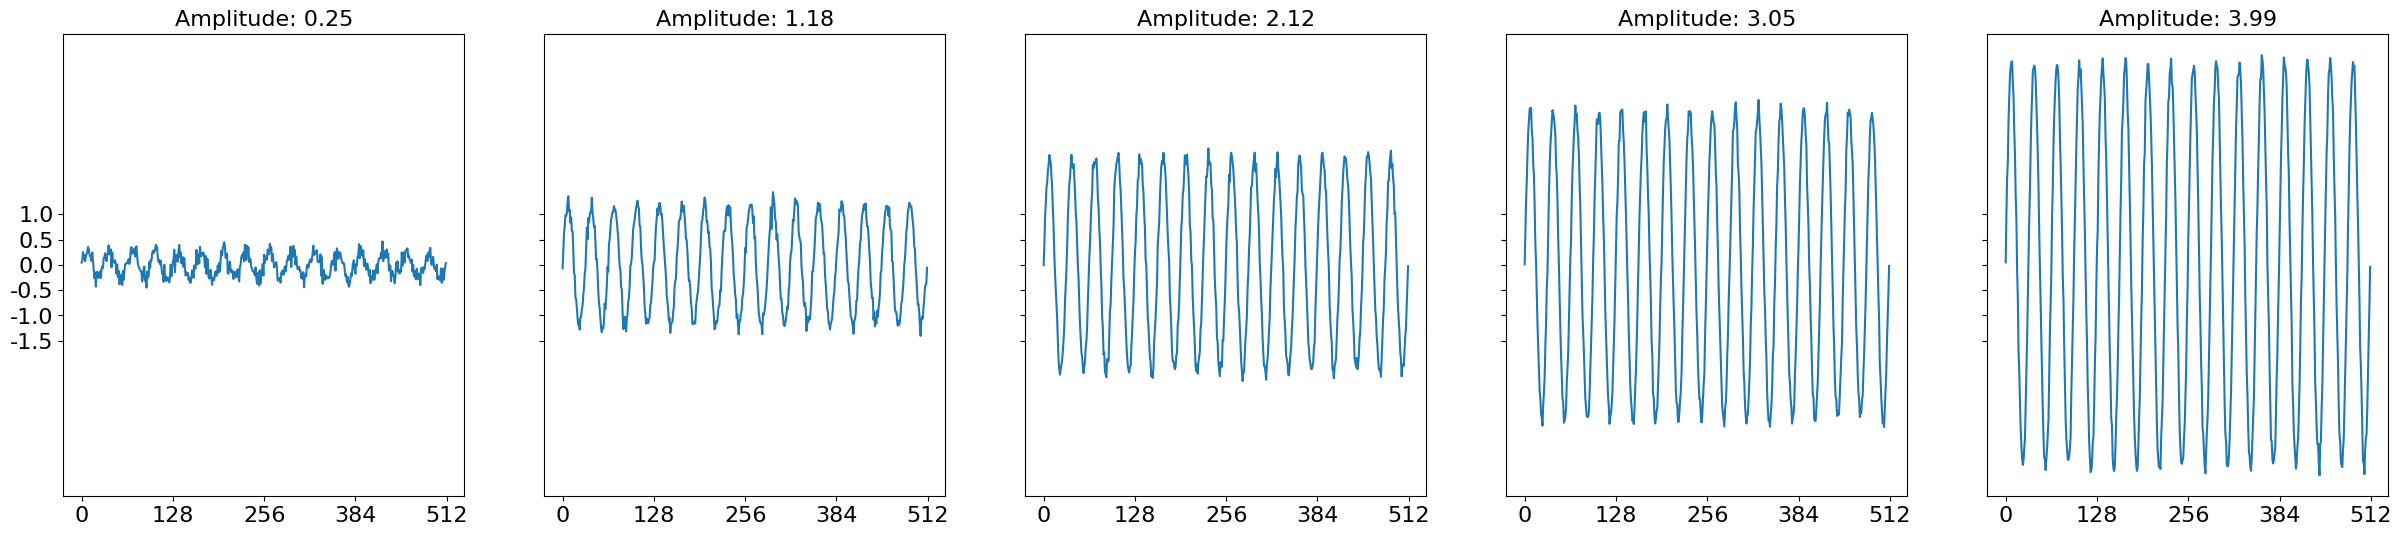

(1024, 513, 1024)


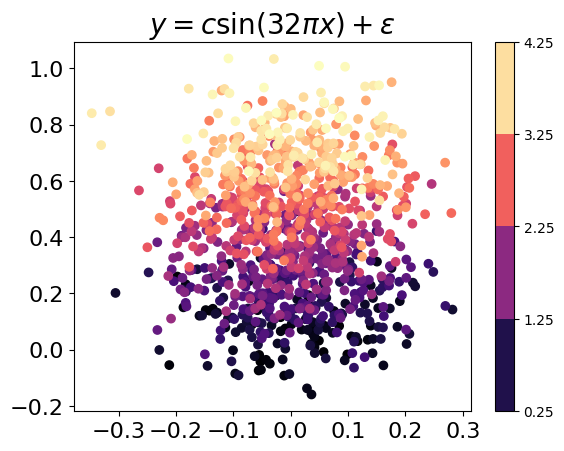

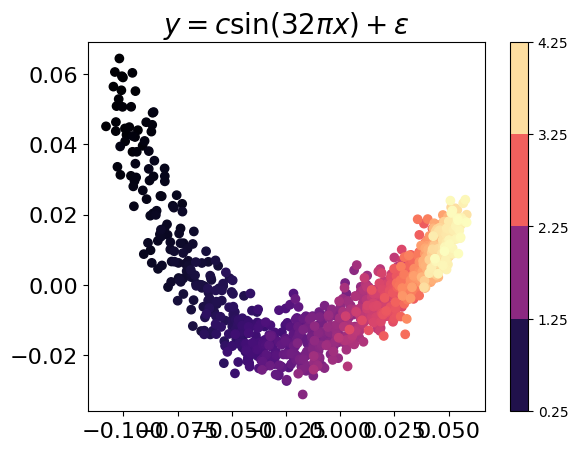

In [6]:
synthetic_dataset = SyntheticDataset(
    n_samples=1024,
    freq=16,
    amplitude_range=(1/4,4), 
    noise_mean=0.,
    noise_std=0.1,
    random_seed=13
)
y, c = synthetic_dataset.gen_sinusoids_with_varying_amplitude()
n_samples = synthetic_dataset.n_samples
seq_len = synthetic_dataset.seq_len
print(y.shape)

fig, axs = plt.subplots(1, 5, figsize=(30, 6), sharey=True)
axs.flatten()
for i, idx in enumerate(np.arange(0, n_samples+1, n_samples//4-1)):
    axs[i].plot(y[idx].squeeze().numpy())
    axs[i].set_xticks(
        ticks=np.arange(0, seq_len+1, 128), 
        labels=np.arange(0, seq_len+1, 128), 
        fontdict={"fontsize" : 16}
    )
    axs[i].set_title(
        "Amplitude: {:.2f}".format(c[:, 0][idx].squeeze().numpy(), ),
        fontsize=16
    )
axs[0].set_yticks(
    ticks=np.arange(-1.5, 1.5, 0.5), 
    labels=np.arange(-1.5, 1.5, 0.5),
    fontdict={"fontsize" : 16}
)
plt.show()

y_s = y.squeeze(1)
# y = y.to("cuda")

with torch.no_grad():
    embeddings, tokenizer_state = pipeline.embed(y_s)

# Move tensors and models back to CPU
y_s = y_s.detach().cpu().numpy()
embeddings = embeddings.detach().to(torch.float32).cpu().numpy()
pooled = embeddings.mean(axis=1)  # shape: [1024, 512]
print(embeddings.shape)
# Perform PCA on the embeddings
embeddings_manifold = PCA(n_components=2).fit_transform(pooled)

plt.title(f"$y = c\sin(32 \pi x) + \epsilon$", fontsize=20)
plt.scatter(
    y_s[:, 0], 
    y_s[:, 1],
    c=c[:, 0].squeeze().numpy(),
    cmap='magma'
)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.colorbar(
    boundaries=np.arange(
    synthetic_dataset.amplitude_range[0],
    synthetic_dataset.amplitude_range[1]+1, 1)
)
plt.show()

plt.title(f"$y = c\sin(32 \pi x) + \epsilon$", fontsize=20)
plt.scatter(
    embeddings_manifold[:, 0], 
    embeddings_manifold[:, 1],
    c=c[:, 0].squeeze().numpy(),
    cmap='magma'
)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.colorbar(
    boundaries=np.arange(
    synthetic_dataset.amplitude_range[0],
    synthetic_dataset.amplitude_range[1]+1, 1)
)
plt.show()

torch.Size([1024, 1, 512])


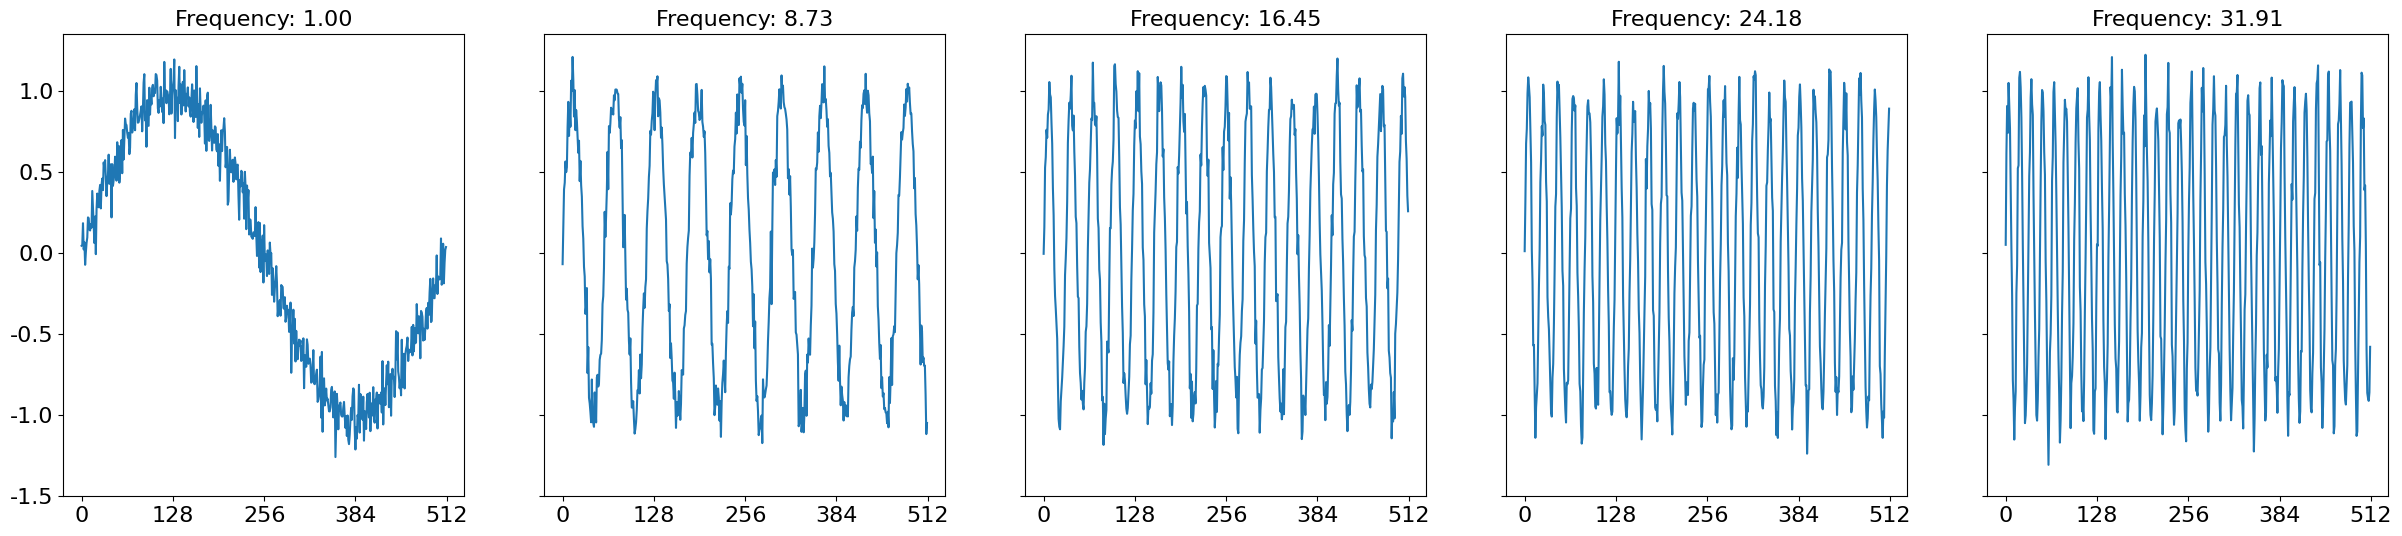

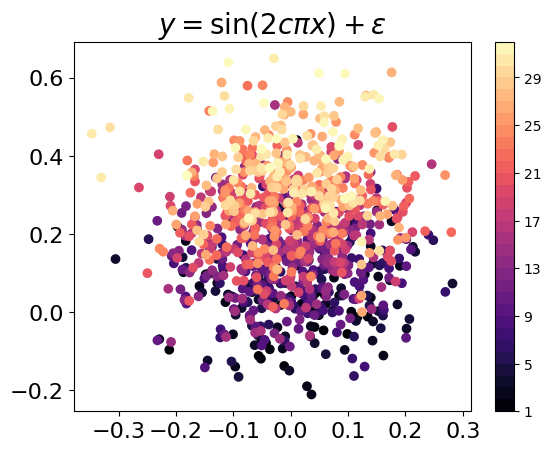

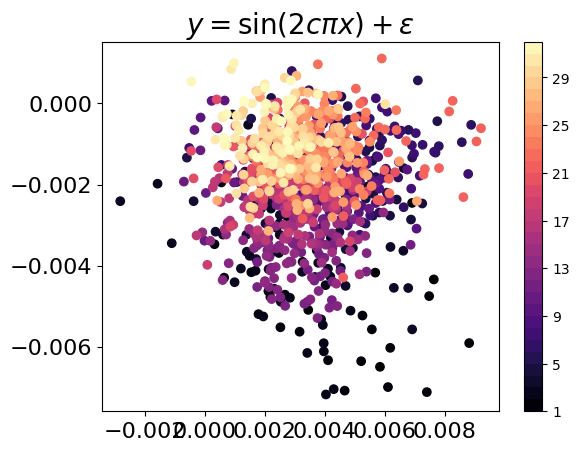

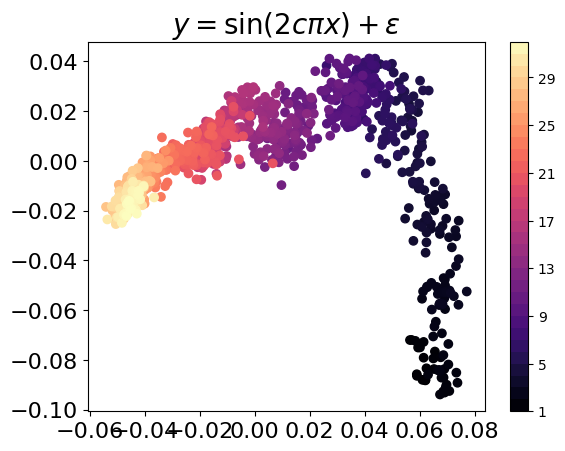

In [7]:
synthetic_dataset = SyntheticDataset(
    n_samples=1024,
    freq=1,
    freq_range=(1, 32), 
    noise_mean=0.,
    noise_std=0.1,
    random_seed=13
)
y, c = synthetic_dataset.gen_sinusoids_with_varying_freq()
n_samples = synthetic_dataset.n_samples
seq_len = synthetic_dataset.seq_len
print(y.shape)

fig, axs = plt.subplots(1, 5, figsize=(30, 6), sharey=True)
axs.flatten()
for i, idx in enumerate(np.arange(0, n_samples+1, n_samples//4-1)):
    axs[i].plot(y[idx].squeeze().numpy())
    axs[i].set_xticks(
        ticks=np.arange(0, seq_len+1, 128), 
        labels=np.arange(0, seq_len+1, 128), 
        fontdict={"fontsize" : 16}
    )
    axs[i].set_title(
        "Frequency: {:.2f}".format(c[:, 0][idx].squeeze().numpy(), ),
        fontsize=16
    )
axs[0].set_yticks(
    ticks=np.arange(-1.5, 1.5, 0.5), 
    labels=np.arange(-1.5, 1.5, 0.5),
    fontdict={"fontsize" : 16}
)
plt.show()

y_s = y.squeeze(1)
# y = y.to("cuda")

with torch.no_grad():
    embeddings, tokenizer_state = pipeline.embed(y_s)

# Move tensors and models back to CPU
y_s = y_s.detach().cpu().numpy()
embeddings = embeddings.detach().to(torch.float32).cpu().numpy()
pooled = embeddings.mean(axis=1)  # shape: [1024, 512]
# Perform PCA on the embeddings
embeddings_manifold = PCA(n_components=2).fit_transform(pooled)


plt.title(f"$y = \sin(2c \pi x) + \epsilon$", fontsize=20)
plt.scatter(
    y_s[:, 0], 
    y_s[:, 1],
    c=c[:, 0].squeeze().numpy(),
    cmap='magma'
)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.colorbar(
    boundaries=np.arange(
    synthetic_dataset.freq_range[0],
    synthetic_dataset.freq_range[1]+1, 1)
)
plt.show()

plt.title(f"$y = \sin(2c \pi x) + \epsilon$", fontsize=20)
plt.scatter(
    pooled[:, 0], 
    pooled[:, 1],
    c=c[:, 0].squeeze().numpy(),
    cmap='magma'
)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.colorbar(
    boundaries=np.arange(
    synthetic_dataset.freq_range[0],
    synthetic_dataset.freq_range[1]+1, 1)
)
plt.show()

plt.title(f"$y = \sin(2c \pi x) + \epsilon$", fontsize=20)
plt.scatter(
    embeddings_manifold[:, 0], 
    embeddings_manifold[:, 1],
    c=c[:, 0].squeeze().numpy(),
    cmap='magma'
)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.colorbar(
    boundaries=np.arange(
    synthetic_dataset.freq_range[0],
    synthetic_dataset.freq_range[1]+1, 1)
)
plt.show()

torch.Size([1024, 1, 512])


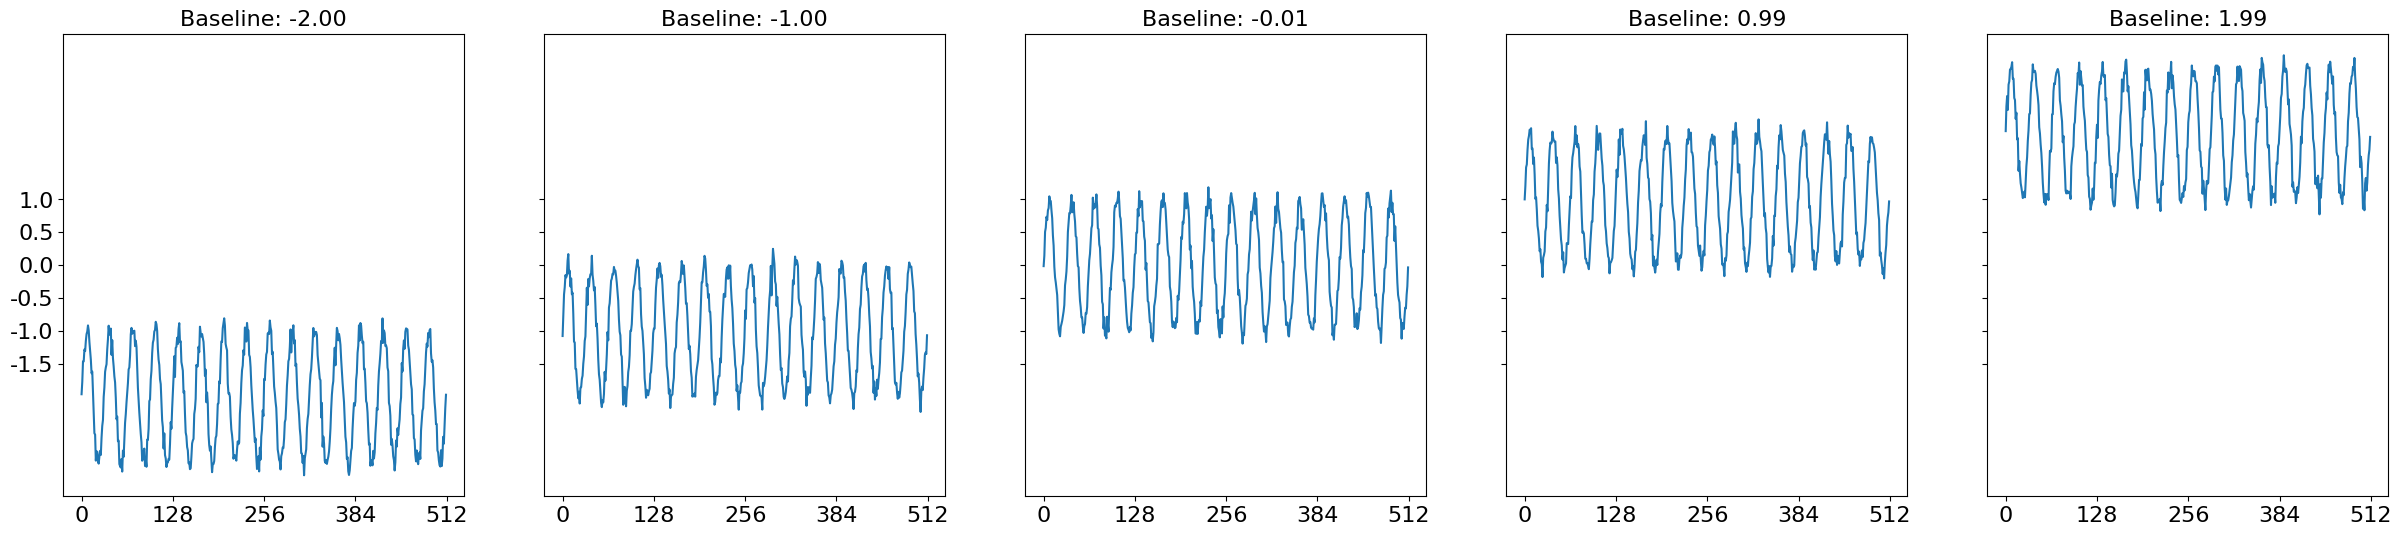

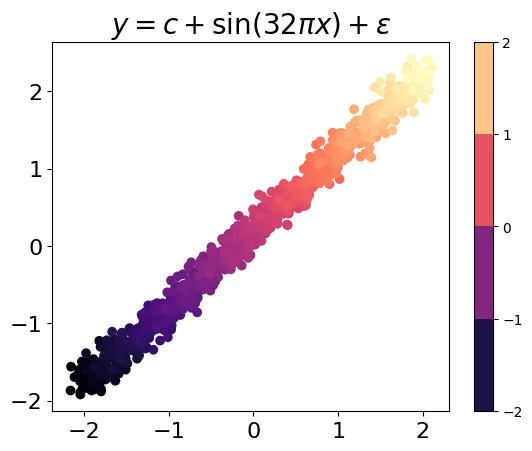

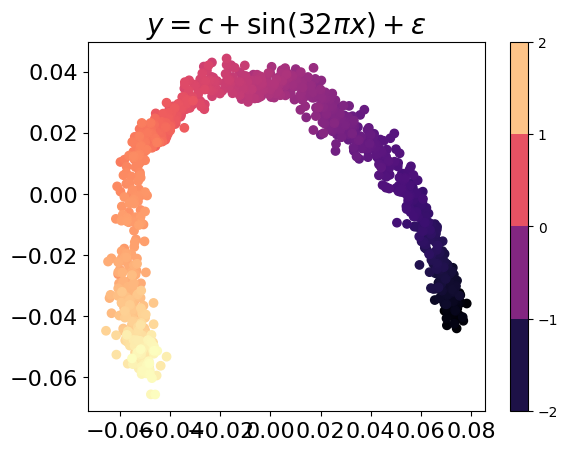

In [8]:
synthetic_dataset = SyntheticDataset(
    n_samples=1024,
    freq=16,
    baseline_range=(-2, 2), 
    noise_mean=0.,
    noise_std=0.1,
    random_seed=13
)
y, c = synthetic_dataset.gen_sinusoids_with_varying_baseline()
n_samples = synthetic_dataset.n_samples
seq_len = synthetic_dataset.seq_len
print(y.shape)

fig, axs = plt.subplots(1, 5, figsize=(30, 6), sharey=True)
axs.flatten()
for i, idx in enumerate(np.arange(0, n_samples+1, n_samples//4-1)):
    axs[i].plot(y[idx].squeeze().numpy())
    axs[i].set_xticks(
        ticks=np.arange(0, seq_len+1, 128), 
        labels=np.arange(0, seq_len+1, 128), 
        fontdict={"fontsize" : 16}
    )
    axs[i].set_title(
        "Baseline: {:.2f}".format(c[:, 0][idx].squeeze().numpy(), ),
        fontsize=16
    )
axs[0].set_yticks(
    ticks=np.arange(-1.5, 1.5, 0.5), 
    labels=np.arange(-1.5, 1.5, 0.5),
    fontdict={"fontsize" : 16}
)
plt.show()

y_s = y.squeeze(1)
# y = y.to("cuda")

with torch.no_grad():
    embeddings, tokenizer_state = pipeline.embed(y_s)

# Move tensors and models back to CPU
y_s = y_s.detach().cpu().numpy()
embeddings = embeddings.detach().to(torch.float32).cpu().numpy()
pooled = embeddings.mean(axis=1)  # shape: [1024, 512]
# Perform PCA on the embeddings
embeddings_manifold = PCA(n_components=2).fit_transform(pooled)

plt.title(f"$y = c+\sin(32\pi x) + \epsilon$", fontsize=20)
plt.scatter(
    y_s[:, 0], 
    y_s[:, 1],
    c=c[:, 0].squeeze().numpy(),
    cmap='magma'
)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.colorbar(
    boundaries=np.arange(
    synthetic_dataset.baseline_range[0],
    synthetic_dataset.baseline_range[1]+1, 1)
)
plt.show()

plt.title(f"$y = c+\sin(32\pi x) + \epsilon$", fontsize=20)
plt.scatter(
    embeddings_manifold[:, 0], 
    embeddings_manifold[:, 1],
    c=c[:, 0].squeeze().numpy(),
    cmap='magma'
)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.colorbar(
    boundaries=np.arange(
    synthetic_dataset.baseline_range[0],
    synthetic_dataset.baseline_range[1]+1, 1)
)
plt.show()


torch.Size([1024, 1, 512])


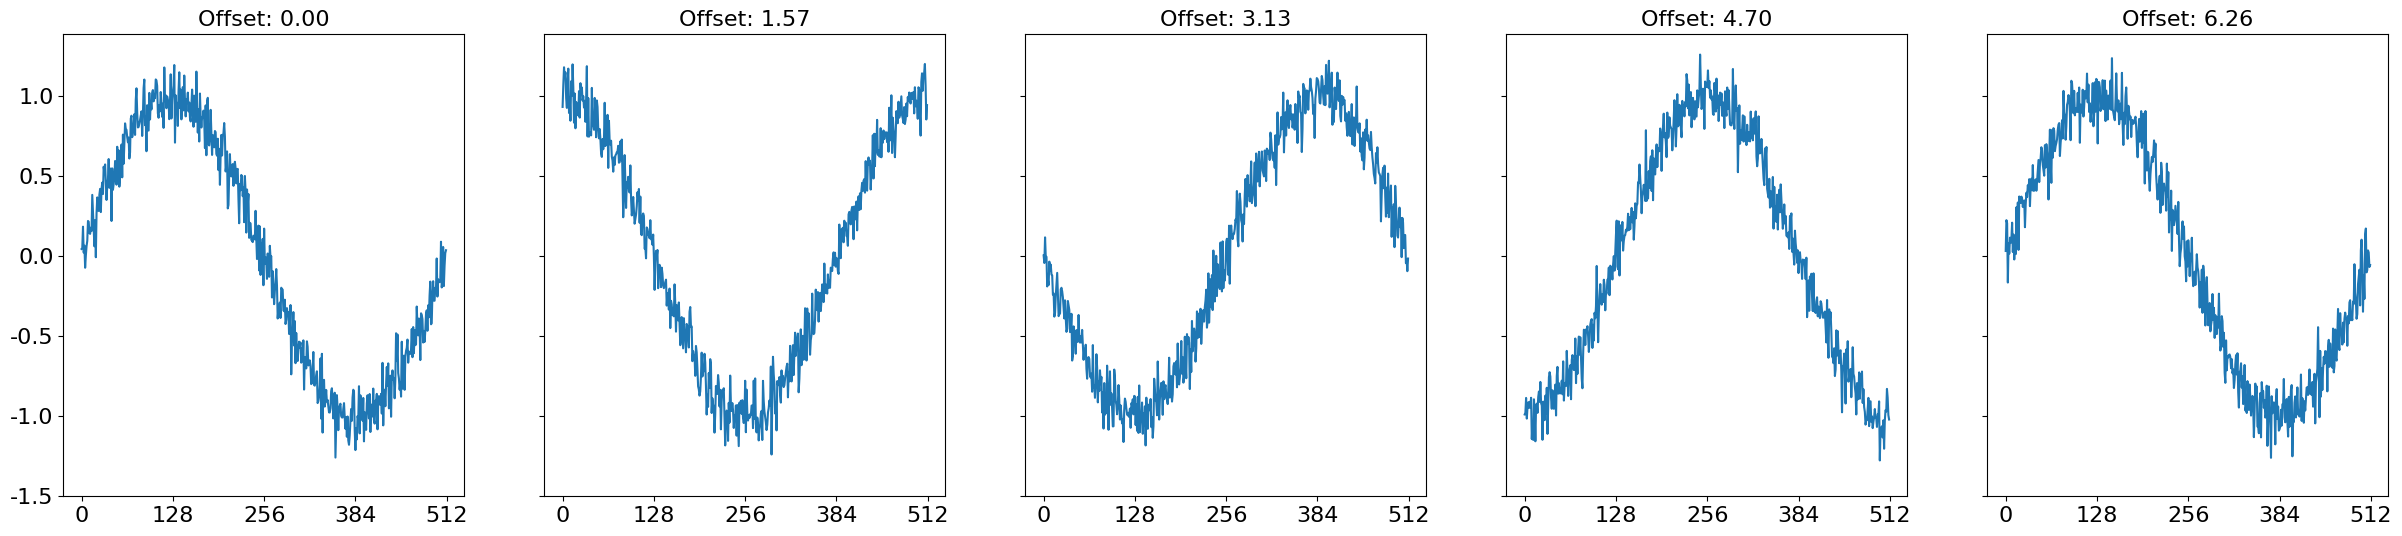

(1024, 513, 1024)


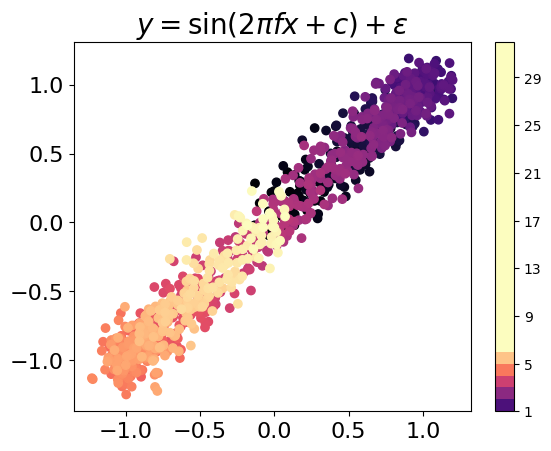

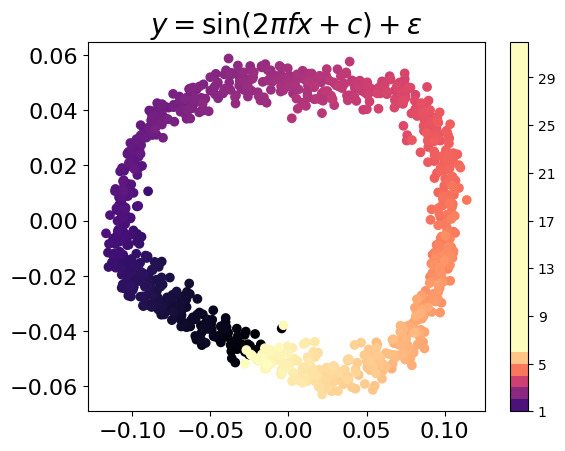

In [9]:
synthetic_dataset = SyntheticDataset(
    n_samples=1024,
    freq=1,
    freq_range=(1, 32), 
    noise_mean=0.,
    noise_std=0.1,
    random_seed=13
)
y, c = synthetic_dataset.gen_sinusoids_with_varying_correlation()
n_samples = synthetic_dataset.n_samples
seq_len = synthetic_dataset.seq_len
print(y.shape)

fig, axs = plt.subplots(1, 5, figsize=(30, 6), sharey=True)
axs.flatten()
for i, idx in enumerate(np.arange(0, n_samples+1, n_samples//4-1)):
    axs[i].plot(y[idx].squeeze().numpy())
    axs[i].set_xticks(
        ticks=np.arange(0, seq_len+1, 128), 
        labels=np.arange(0, seq_len+1, 128), 
        fontdict={"fontsize" : 16}
    )
    axs[i].set_title(
        "Offset: {:.2f}".format(c[:, 0][idx].squeeze().numpy(), ),
        fontsize=16
    )
axs[0].set_yticks(
    ticks=np.arange(-1.5, 1.5, 0.5), 
    labels=np.arange(-1.5, 1.5, 0.5),
    fontdict={"fontsize" : 16}
)
plt.show()

y_s = y.squeeze(1)
# y = y.to("cuda")

with torch.no_grad():
    embeddings, tokenizer_state = pipeline.embed(y_s)

# Move tensors and models back to CPU
y_s = y_s.detach().cpu().numpy()
embeddings = embeddings.detach().to(torch.float32).cpu().numpy()
pooled = embeddings.mean(axis=1)  # shape: [1024, 512]
print(embeddings.shape)
# Perform PCA on the embeddings
embeddings_manifold = PCA(n_components=2).fit_transform(pooled)

plt.title(f"$y = \sin(2\pi f x+c) + \epsilon$", fontsize=20)
plt.scatter(
    y_s[:, 0], 
    y_s[:, 1],
    c=c[:, 0].squeeze().numpy(),
    cmap='magma'
)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.colorbar(
    boundaries=np.arange(
    synthetic_dataset.freq_range[0],
    synthetic_dataset.freq_range[1]+1, 1)
)
plt.show()

plt.title(f"$y = \sin(2\pi f x+c) + \epsilon$", fontsize=20)
plt.scatter(
    embeddings_manifold[:, 0], 
    embeddings_manifold[:, 1],
    c=c[:, 0].squeeze().numpy(),
    cmap='magma'
)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.colorbar(
    boundaries=np.arange(
    synthetic_dataset.freq_range[0],
    synthetic_dataset.freq_range[1]+1, 1)
)
plt.show()